<a href="https://colab.research.google.com/github/nicolassalomon96/procesamiento_imagenes_UNS/blob/main/TP7/Procesamiento_Morfol%C3%B3gico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP7 - Procesamiento Morfológico de Imágenes

Presentado: Nicolás Salomón - email: nicolassalomon96@gmail.com

Desarrollar un aplicativo que permita abrir una imagen y automáticamente convertirla a niveles de grises (en caso de no estarlo) y visualizarla. Con esta imagen se aplicarán los siguientes filtros morfológicos, los cuales deben poderse seleccionar de una lista:
- Erosión (tomar el mínimo valor de luminancia de la vecindad).
- Dilatación (máximo)
- Apertura
-Cierre
- Borde morfológico (frontera interna y externa)
- Mediana
- Top-hat

El elemento estructurante será de una ventana de 3x3 pixeles.

El aplicativo debe incluir una función de copiado de la imagen procesada, de tal manera que esta pueda tomarse como imagen de entrada para así poder aplicar dos o más filtros en secuencia.
El resultado del filtro debe poder guardarse como una nueva imagen en nivel de grises.

Adicionalmente se debe mostrar un plot con el resultado respectivo para cada uno de los filtros indicados.
Nota: La función que desarrollaron para la convolución es la misma que pueden usar para recorrer toda la imagen y aplicar el filtro morfológico.

## 1. Librerias necesarias

In [ ]:
import os
import numpy as np
import imageio as io
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

## 2. Funciones necesarias

In [ ]:
#Función para pasar de RGB a escala de grises
def rgb2gray(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  gray = 0.299 * r + 0.587 * g + 0.114 * b
  return gray

#Función para descargar imagen
def get_image(path):
  image = io.imread(path)
  image = rgb2gray(image)
  return image.astype('uint8')

#Función para plotear una imagen
def plot_image(image, title, figsize=(10,6)):
  fig, axs = plt.subplots(figsize=figsize)
  plt.imshow(image, cmap='gray')
  plt.title(title, fontsize=14)
  plt.axis('off')

#Función para plotear dos imágenes
def plot_2images(image, title_1, image_mod, title_2, figsize=(20,8)):
  fig, axs = plt.subplots(1,2,figsize=figsize)

  plt.subplot(1,2,1)
  plt.imshow(image, cmap='gray')
  plt.title(title_1, fontsize=14)
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(image_mod, cmap='gray')
  plt.title(title_2, fontsize=14)
  plt.axis('off')  

  plt.show()

#Función para plotear tres imágenes
def plot_3images(image1, title_1, image2, title_2, image3, title_3, figsize=(30,8)):
  fig, axs = plt.subplots(1,3,figsize=figsize)

  plt.subplot(1,3,1)
  plt.imshow(image1, cmap='gray')
  plt.title(title_1, fontsize=20)
  plt.axis('off')

  plt.subplot(1,3,2)
  plt.imshow(image2, cmap='gray')
  plt.title(title_2, fontsize=20)
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.imshow(image3, cmap='gray')
  plt.title(title_3, fontsize=20)
  plt.axis('off')  

  plt.show()

#Función para agregar bordes a la imagen para realizar la convolución. Permite copiar bordes o realizar un 0-padding
def add_borders(image, filter_size=3, method=0):
  '''
  image = imagen en escala de grises
  filter_size = tamaño del kernel
  method = 0 --> copiar fila o columna más cercana
           1 --> realizar un 0-padding en los bordes
  '''
  if method == 0:
    first_column = image[:,0]
    last_column = image[:,-1]
    image_mod = np.copy(image)

    for i in range(filter_size//2):
      image_mod = np.insert(image_mod,0,first_column,axis=1)
      image_mod = np.insert(image_mod,image_mod.shape[1],last_column,axis=1)

    first_raw = image_mod[0,:]
    last_raw = image_mod[-1,:]

    for i in range(filter_size//2):
      image_mod = np.insert(image_mod,0,first_raw,axis=0)
      image_mod = np.insert(image_mod,image_mod.shape[0],last_raw,axis=0)


  if method == 1:
    column = np.zeros(image.shape[0]).astype(int)
    image_mod = np.copy(image)
    for i in range(filter_size//2):
      image_mod = np.insert(image_mod,0,column,axis=1)
      image_mod = np.insert(image_mod,image_mod.shape[1],column,axis=1)

    raw = np.zeros(image_mod.shape[1]).astype(int)

    for i in range(filter_size//2):
      image_mod = np.insert(image_mod,0,raw,axis=0)
      image_mod = np.insert(image_mod,image_mod.shape[0],raw,axis=0)

  return image_mod.astype('uint8')

#Función para realizar la convolución entre una imagen y un kernel
def sliding_window(image, element_size, function, method=0):

  #image = imagen en escala de grises
  #element_size = tamaño del elemento estructurante
  #method = 0 --> copiar fila o columna más cercana
  #         1 --> realizar un 0-padding en los bordes
  #function = funcion a implementar

  if function == 'erosion':
    image_out = make_erosion(image, element_size, method)
  if function == 'dilatacion':
    image_out = make_dilatation(image, element_size, method)
  if function == 'apertura':
    image_out = make_aperture(image, element_size, method)  
  if function == 'cierre':
    image_out = make_closure(image, element_size, method)  
  if function == 'borde_exterior':
    image_out = make_outer_edge(image, element_size, method)  
  if function == 'borde_interior':
    image_out = make_inner_edge(image, element_size, method)  
  if function == 'gradiente':
    image_out = make_gradient(image, element_size, method)
  if function == 'mediana':
    image_out = make_median(image, element_size, method)
  if function == 'top_hat':
    image_out = make_top_hat(image, element_size, method)  

  return image_out

#Función para implementar: erosión
def make_erosion(image, element_size, method):
  image_out = np.zeros(image.shape)
  image_mod = add_borders(image, element_size, method)
  for x in range(element_size//2,image_mod.shape[0]-element_size//2):
    for y in range(element_size//2,image_mod.shape[1]-element_size//2):
      pixel = 0
      box = image[x-element_size//2:x+element_size//2+1,y-element_size//2:y+element_size//2+1]
      pixel = np.amin(box)
      image_out[x-element_size//2,y-element_size//2] = pixel
  
  image_out = np.clip(image_out,0,255)

  return image_out.astype('uint8')

#Función para implementar: dilatación
def make_dilatation(image, element_size, method):
  image_out = np.zeros(image.shape)
  image_mod = add_borders(image, element_size, method)

  for x in range(element_size//2,image_mod.shape[0]-element_size//2):
    for y in range(element_size//2,image_mod.shape[1]-element_size//2):
      pixel = 0
      box = image[x-element_size//2:x+element_size//2+1,y-element_size//2:y+element_size//2+1]
      pixel = np.amax(box)
      image_out[x-element_size//2,y-element_size//2] = pixel
  
  image_out = np.clip(image_out,0,255)

  return image_out.astype('uint8')

#Función para implementar: apertura
def make_aperture(image, element_size, method):
  image_out = np.zeros(image.shape)
  image_out_2 = np.zeros(image.shape)
  
  image_out = make_erosion(image, element_size, method)
  image_out_2 = make_dilatation(image_out, element_size, method)

  return image_out_2.astype('uint8')

#Función para implementar: cierre
def make_closure(image, element_size, method):
  image_out = np.zeros(image.shape)
  image_out_2 = np.zeros(image.shape)

  image_out = make_dilatation(image, element_size, method) 
  image_out_2 = make_erosion(image_out, element_size, method)

  return image_out_2.astype('uint8')

#Función para implementar: borde morfológico (frontera externa)
def make_outer_edge(image, element_size, method):
  image_out = np.zeros(image.shape)
  image_out_2 = np.zeros(image.shape)

  image_out = make_dilatation(image, element_size, method) 
  image_out_2 = image_out - image
  
  return image_out_2.astype('uint8')

#Función para implementar: borde morfológico (frontera interna)  
def make_inner_edge(image, element_size, method):
  image_out = np.zeros(image.shape)
  image_out_2 = np.zeros(image.shape)

  image_out = make_erosion(image, element_size, method) 
  image_out_2 = image - image_out
  
  return image_out_2.astype('uint8')

#Función para implementar: gradiente
def make_gradient(image, element_size, method):
  
  image_out = np.zeros(image.shape)
  image_out_erosion = np.zeros(image.shape)
  image_out_dilatation = np.zeros(image.shape)

  image_out_dilatation = make_dilatation(image, element_size, method) 
  image_out_erosion = make_erosion(image, element_size, method)

  image_out = image_out_dilatation - image_out_erosion
  return image_out.astype('uint8')

#Función para implementar: mediana
def make_median(image, element_size, method):
  image_out = np.zeros(image.shape)
  image_mod = add_borders(image, element_size, method)

  for x in range(element_size//2,image_mod.shape[0]-element_size//2):
    for y in range(element_size//2,image_mod.shape[1]-element_size//2):
      pixel = 0
      box = image[x-element_size//2:x+element_size//2+1,y-element_size//2:y+element_size//2+1]
      pixel = np.median(box).astype(int)
      image_out[x-element_size//2,y-element_size//2] = pixel
  
  image_out = np.clip(image_out,0,255)

  return image_out.astype('uint8')

#Función para implementar: top_hat
def make_top_hat(image, element_size, method):
  image_out = np.zeros(image.shape)
  image_out_2 = np.zeros(image.shape)

  image_out = make_aperture(image, element_size, method) 
  image_out_2 = image - image_out
  
  return image_out_2.astype('uint8')


#Función para guardar una imagen
def save_image(image,path):
  image = image.astype('uint8')
  io.imsave(path,image)

#Funcion para crear un botones de guardado
def buttons(image, path):

  save_button = widgets.Button(description='SAVE .PNG')
  save_local_button = widgets.Button(description='SAVE LOCAL')
  out = widgets.Output()

  def save_button_clicked(b):
     with out:
      #Que sucede al presionar el boton
      out.clear_output()
      save_image(image,os.path.join(path,'processed_image.png'))     
      print("Imagen guardada como .png")

  save_button.on_click(save_button_clicked)

  def save_local_button_clicked(b):

     global new_image
     with out:
      #Que sucede al presionar el boton
      out.clear_output()
      new_image = np.copy(image)
      print("Imagen guardada localmente")

  save_local_button.on_click(save_local_button_clicked)
  buttons = widgets.HBox([save_button, save_local_button])
  display(buttons,out)


## 3. Aplicativo Interactivo

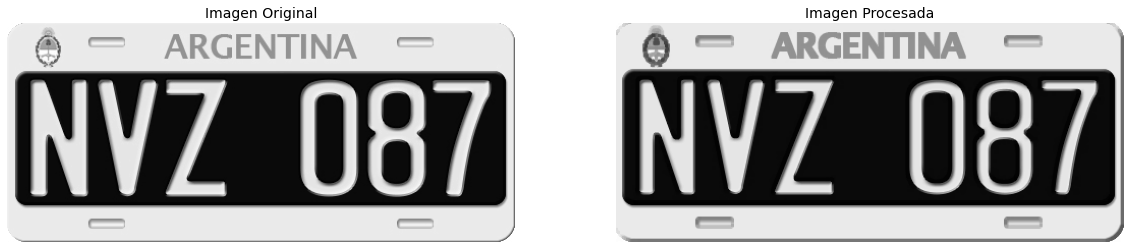

Output()

In [ ]:
#@title Seleccione la imagen a analizar: { run: "auto" }
huella = 'https://st.depositphotos.com/1011833/1279/i/600/depositphotos_12794349-stock-photo-fingerprint-pattern-isolated-on-white.jpg'
letras = 'https://www.microsiervos.com/images/gardner-HOMERO.png'
patente = 'https://upload.wikimedia.org/wikipedia/commons/d/d7/Matr%C3%ADcula_automovil%C3%ADstica_Argentina_1995_NVZ_087.jpg'

Imagen = 'patente' #@param ["patente", "huella", "letras", "guardada"]

if Imagen =='huella':
  image = get_image(huella)
if Imagen =='letras':
  image = get_image(letras)
if Imagen =='patente':
  image = get_image(patente)
if Imagen =='guardada':
  image = new_image

#@markdown Seleccione el tamaño del elemento estructurante: { run: "auto" }
Tamaño = "3" #@param [3, 5, 7]
Tamaño = int(Tamaño)

#@markdown Seleccione la operación a realizar: { run: "auto" }
Operacion = 'erosion' #@param ["erosion","dilatacion","apertura","cierre","borde_exterior","borde_interior","gradiente","mediana","top_hat"]
processed_image = sliding_window(image, Tamaño, Operacion)

plot_2images(image, 'Imagen Original', processed_image, 'Imagen Procesada')

#@markdown Modo de uso: Seleccione la imagen a procesar, junto con el tamaño del elemento estructurante y la operación.
#@markdown Para efectuar varias operaciones seguidas tomando la salida anterior, guardar la imagen localmente (SAVE LOCAL) y en imagen seleccionar "guardada"
#@markdown junto con el tamaño del elemento estructurante y la operación.
#@markdown Para guardar la imagen resultante como .PNG hacer click en "SAVE .PNG".

#Botones de guardado
print('\n')
buttons(processed_image,'/content')
print('\n')


## 4. Ploteo de todas las funciones aplicada a la misma imagen

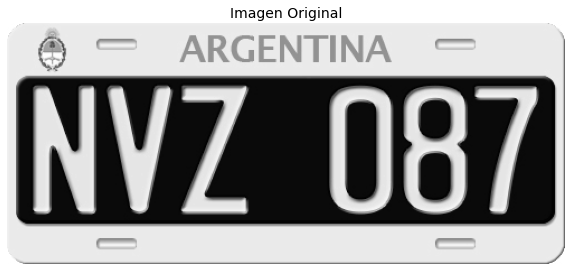

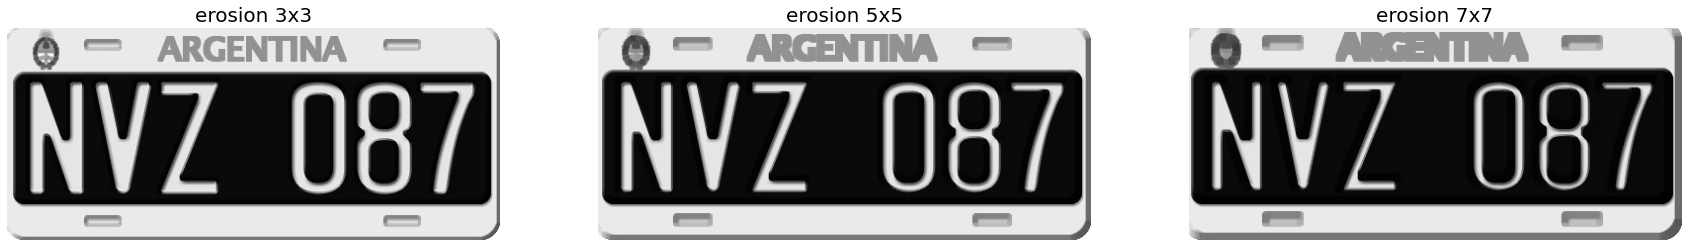

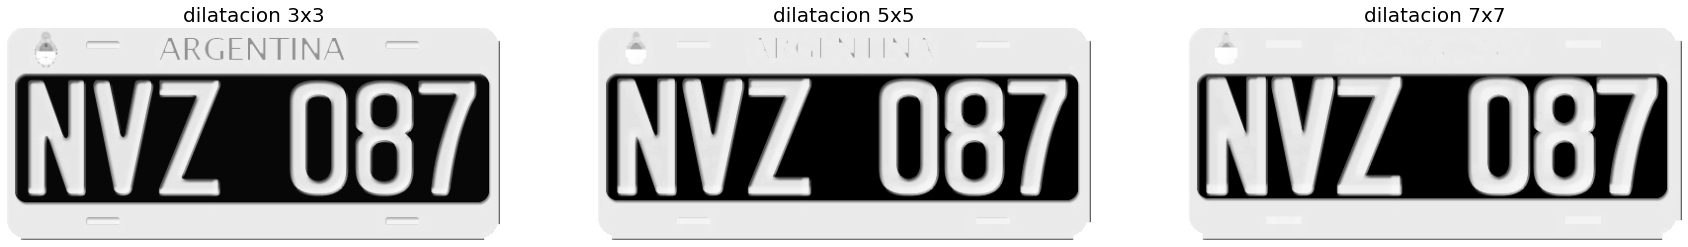

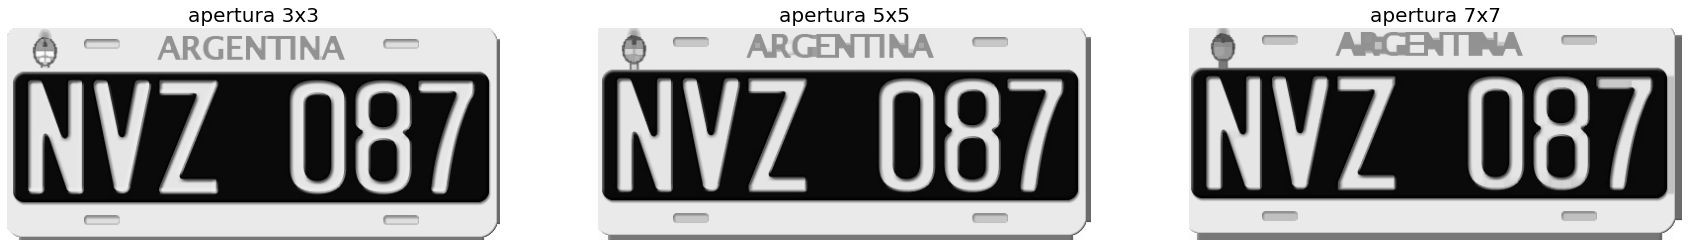

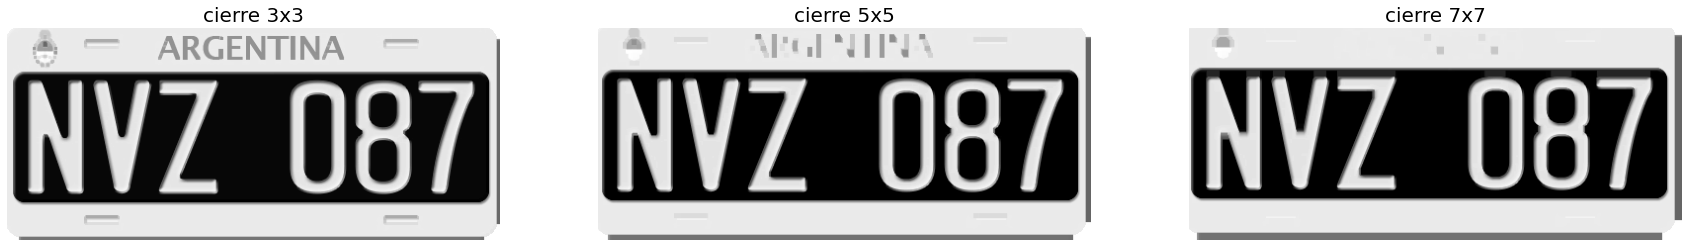

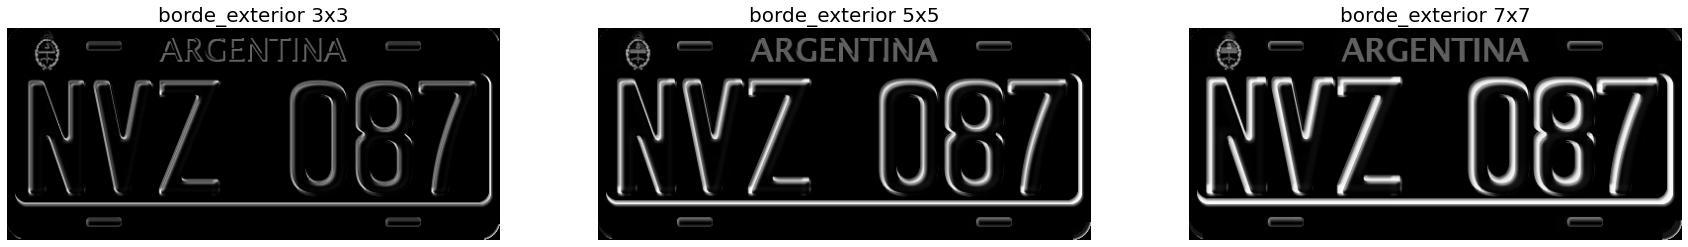

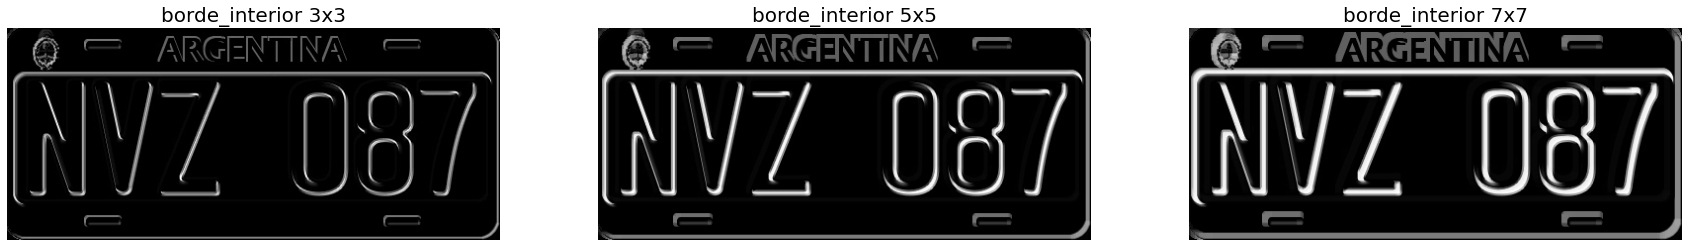

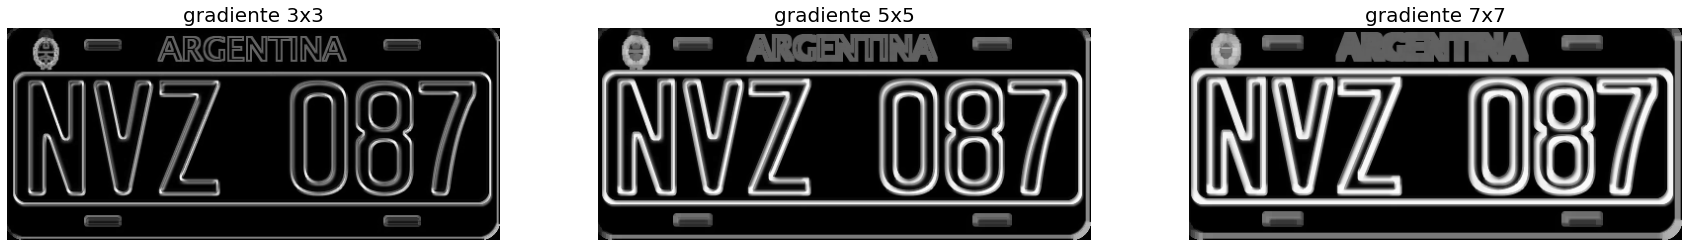

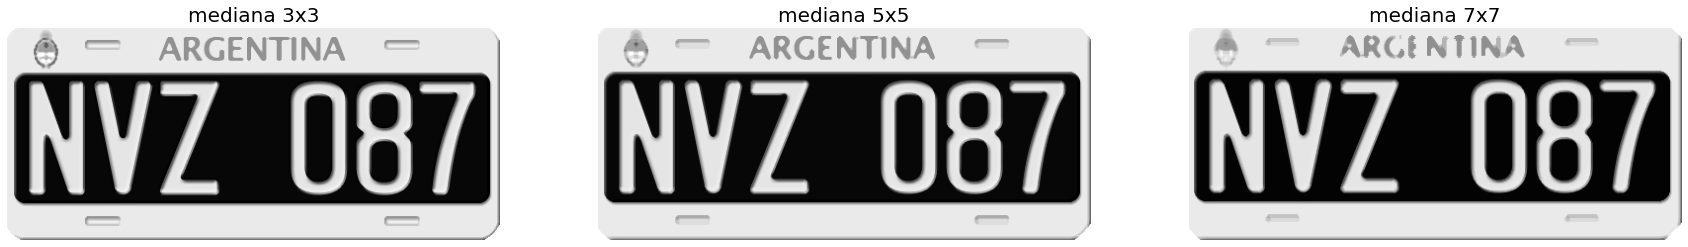

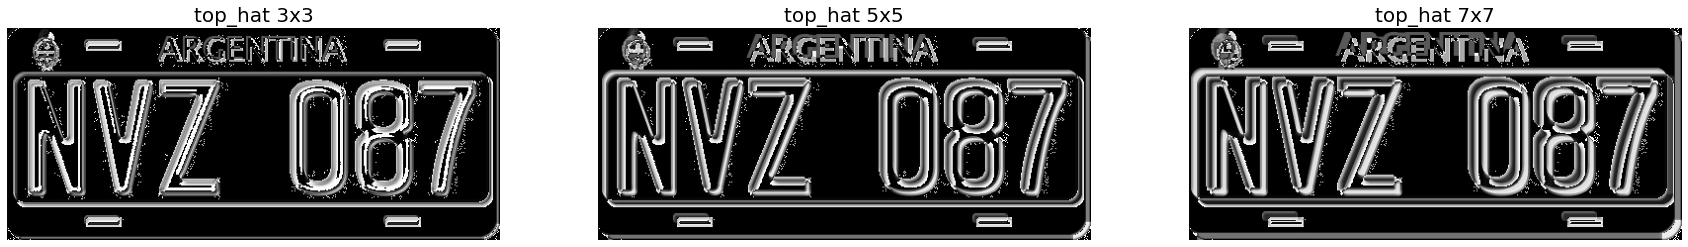

In [ ]:
plot_image(image,'Imagen Original')

operation_list = ["erosion","dilatacion","apertura","cierre","borde_exterior","borde_interior","gradiente","mediana","top_hat"]
rows, columns = 9, 1

for i in range(rows * columns):
  image_3x3 = sliding_window(image, 3, operation_list[i])
  image_5x5 = sliding_window(image, 5, operation_list[i])
  image_7x7 = sliding_window(image, 7, operation_list[i])

  plot_3images(image_3x3, operation_list[i]+' 3x3', image_5x5, operation_list[i]+' 5x5', image_7x7, operation_list[i]+' 7x7')

## 5. Conclusiones

* Dada la naturaleza de la operación de erosión y dilatación (tomar el pixel de mínimo o máximo valor respectivamente del elemento estructurante) como dicha operación invierte su resultado si la zona de la imagen tiene fondo negro y letras blancas o fondo blanco y letras negras.

* Se observa un efecto mucho mas pronunciado o notorio al emplear un elementos estructurante de mayor tamaño (5x5 o 7x7) dado que dicho elemento tiene una mayor cantidad de píxeles en su interior.

* Se puede apreciar como las operaciones de borde interior y borde exterior logran resaltar los bordes la imagen, en especial los de las letras de la patente.

* Es de especial interés el resultado obtenido al aplicar el gradiente, dado que logra encontrar todos los bordes de interés (letras y números), siendo esto de especial importancia en sistemas de detección de patentes, por ejemplo.

* La operación de mediana en este caso parecería no tener demasiado resultado, dado que la imagen original casi no poseía ruido alguno, por lo tanto solo suaviza la imagen, al igual que el filtro Gaussiano, pero sin afectar los bordes.

* Por último, se observa en la operación de top-hat como resaltan aquellas zonas que tienen alta luminancia y cuyas zonas son más pequeñas que el elemento estructurante. Por otro lado, las imperfecciones o ruido que se aprecia en la imagen de salida pueden explicarse debido a las imperfecciones propias de la imagen original en los bordes de las letras y números por ejemplo.